# Final Project 

## "Forecasting the winner of tennis matches in the Men’s ATP World Tour"


## Problem Statement

The goal of the project is to predict the probability that the higher-ranked player will win a tennis match. We will call that a `win`. This can be stated more formally as:

For two players ${\cal P}_1$ and ${\cal P}_2$ where ${{\rm Rank}_1} > {{\rm Rank}_2}$ we calculate the probability that ${\cal P}_1$ will win the match, or that a `win` will happen.


## Dataset

Results for the men's ATP tour date back to January 2000 from the dateset http://www.tennis-data.co.uk/data.php (obtained from Kaggle). The original dataset is shown below.

In [69]:
import pandas as pd
df_atp = pd.read_csv('Data.csv')
df_atp.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Features 

The features for each match that were used in the project follow:
- `Date`: date of the match 
- `Series`: name of ATP tennis series (we kept the four main current categories namely Grand Slams, Masters 1000, ATP250, ATP500)
- `Surface`: type of surface (clay, hard or grass)
- `Round`: round of match (from first round to the final)
- `Best of`: maximum number of sets playable in match (Best of 3 or Best of 5)
- `WRank`: ATP Entry ranking of the match winner as of the start of the tournament
- `LRank`: ATP Entry ranking of the match loser as of the start of the tournament

The output variable is binary. The better player has higher rank by definition. We define the `win` variable by:

${\rm{win}} = \left\{ {\begin{array}{*{20}{c}}
1&{{\rm{higher\,\,ranked\,\,player\,\, wins}}}\\
0&{{\rm{higher\,\,ranked\,\,player\,\, loses}}}
\end{array}} \right.$

## Importing basic modules

In [70]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
sns.set_style("darkgrid")
import pylab as pl
%matplotlib inline

## Pre-Processing of dataset

After loading the dataset we proceed as following:
- Keep only completed matches i.e. eliminate matches with injury withdrawals and walkovers.
- For convenience we rename `Best of` to `Best_of`
- Choose the features listed above
- Drop `NaN` entries
- Consider the two final years only (to avoid comparing different categories of tournaments which existed in the past). We note that this choice is somewhat arbitrary and can be changed if needed.
- Choose only higher ranked players for better accuracy (as suggested by Corral and Prieto-Rodriguez (2010) and confirmed here)

In [71]:
df_atp['Date'] = pd.to_datetime(df_atp['Date']) 
# Restricing dates
df_atp = df_atp.loc[(df_atp['Date'] > '2014-11-09') & (df_atp['Date'] <= '2016-11-09')]
# Keeping only completed matches
df_atp = df_atp[df_atp['Comment'] == 'Completed'].drop("Comment",axis = 1)
# Rename Best of to Best_of
df_atp.rename(columns = {'Best of':'Best_of'},inplace=True)
# Choosing features
cols_to_keep = ['Date','Series','Surface', 'Round','Best_of', 'WRank','LRank']
# Dropping NaN
df_atp = df_atp[cols_to_keep].dropna()
# Dropping errors in the dataset and unimportant entries (e.g. there are very few entries for Masters Cup)
df_atp = df_atp[(df_atp['LRank'] != 'NR') & (df_atp['WRank'] != 'NR') & (df_atp['Series'] != 'Masters Cup')]
df_atp.head()

,Date,Series,Surface,Round,Best_of,WRank,LRank
39530,2014-12-02,ATP250,Clay,1st Round,3,92,42
39531,2014-12-02,ATP250,Clay,1st Round,3,45,78
39532,2014-12-02,ATP250,Clay,1st Round,3,53,230
39533,2014-12-02,ATP250,Clay,1st Round,3,84,165
39534,2014-12-02,ATP250,Clay,1st Round,3,18,111


In [72]:
# Transform strings into numerical values
df_atp[['Best_of','WRank','LRank']] = df_atp[['Best_of','WRank','LRank']].astype(int)
df_atp.head()

,Date,Series,Surface,Round,Best_of,WRank,LRank
39530,2014-12-02,ATP250,Clay,1st Round,3,92,42
39531,2014-12-02,ATP250,Clay,1st Round,3,45,78
39532,2014-12-02,ATP250,Clay,1st Round,3,53,230
39533,2014-12-02,ATP250,Clay,1st Round,3,84,165
39534,2014-12-02,ATP250,Clay,1st Round,3,18,111


We now create an extra columns for the variable `win` described above using an auxiliary function `win(x)`

In [73]:
def win(x):
    if x > 0:
        return 0
    elif x <= 0:
        return 1  
    
df_atp['win'] = (df_atp['WRank'] - df_atp['LRank']).apply(win)
df_atp.head()

,Date,Series,Surface,Round,Best_of,WRank,LRank,win
39530,2014-12-02,ATP250,Clay,1st Round,3,92,42,0
39531,2014-12-02,ATP250,Clay,1st Round,3,45,78,1
39532,2014-12-02,ATP250,Clay,1st Round,3,53,230,1
39533,2014-12-02,ATP250,Clay,1st Round,3,84,165,1
39534,2014-12-02,ATP250,Clay,1st Round,3,18,111,1


Following Corral and Prieto-Rodriguez (2010) we restrict the analysis to higher ranked players (the analysis including all players has indeed less predictive power as we tested)

In [9]:
newdf = df_atp.copy()
newdf2 = newdf[(newdf['WRank'] <= 150) & (newdf['LRank'] <= 150)]
newdf2.head()

,Date,Series,Surface,Round,Best_of,WRank,LRank,win
39530,2014-12-02,ATP250,Clay,1st Round,3,92,42,0
39531,2014-12-02,ATP250,Clay,1st Round,3,45,78,1
39534,2014-12-02,ATP250,Clay,1st Round,3,18,111,1
39536,2014-12-02,ATP250,Clay,2nd Round,3,17,108,1
39537,2014-12-02,ATP250,Clay,2nd Round,3,14,58,1


##  Best_of = 5
We now restrict our analysis to matches of Best_of = 5. Since only Grand Slams have 5 sets we can drop the new `Series` column. The case of Best_of = 3 will be considered afterwards.

In [10]:
df3 = newdf2.copy()
df3 = df3[df3['Best_of'] == 5]
# Drop Best_of and Series columns
df3.drop("Series",axis = 1,inplace=True)
df3.drop("Best_of",axis = 1,inplace=True)
df3.head()

,Date,Surface,Round,WRank,LRank,win
41911,2015-01-19,Hard,1st Round,85,84,0
41912,2015-01-19,Hard,1st Round,11,90,1
41913,2015-01-19,Hard,1st Round,15,59,1
41914,2015-01-19,Hard,1st Round,31,91,1
41915,2015-01-19,Hard,1st Round,99,98,0


Now we notice that our dataset is uneven in terms of frequency of `wins`:

In [11]:
print(df3['win'].sum(axis=0))
print(len(df3.index))
df3['win'].sum(axis=0)/float(len(df3.index))

618
816


0.7573529411764706

To correct this problem, and create a balanced dataset, we use a stratified sampling procedure. 

In [12]:
y_0 = df3[df3.win == 0] 
y_1 = df3[df3.win == 1] 
n = min([len(y_0), len(y_1)]) 
y_0 = y_0.sample(n = n, random_state = 0) 
y_1 = y_1.sample(n = n, random_state = 0)
df_strat = pd.concat([y_0, y_1]) 
X_strat = df_strat[['Date', 'Surface', 'Round','WRank', 'LRank']]
y_strat = df_strat.win

In [13]:
X_strat.head()

,Date,Surface,Round,WRank,LRank
41984,2015-01-21,Hard,2nd Round,46,31
46044,2016-08-07,Grass,Semifinals,7,3
43308,2015-06-29,Grass,1st Round,148,93
46497,2016-08-29,Hard,1st Round,120,54
43345,2015-06-30,Grass,1st Round,37,32


In [14]:
y_strat.head()

41984    0
46044    0
43308    0
46497    0
43345    0
Name: win, dtype: int64

In [15]:
X_strat_1=X_strat.copy()
X_strat_1['win']=y_strat
X_strat_1.head()

,Date,Surface,Round,WRank,LRank,win
41984,2015-01-21,Hard,2nd Round,46,31,0
46044,2016-08-07,Grass,Semifinals,7,3,0
43308,2015-06-29,Grass,1st Round,148,93,0
46497,2016-08-29,Hard,1st Round,120,54,0
43345,2015-06-30,Grass,1st Round,37,32,0


We now define the variables ${\cal P}_1$ and ${\cal P}_2$ where ${{\rm Rank}_1} > {{\rm Rank}_2}$

In [17]:
df = X_strat_1.copy()
df["P1"] = df[["WRank", "LRank"]].max(axis=1)
df["P2"] = df[["WRank", "LRank"]].min(axis=1)
df.head()

,Date,Surface,Round,WRank,LRank,win,P1,P2
41984,2015-01-21,Hard,2nd Round,46,31,0,46,31
46044,2016-08-07,Grass,Semifinals,7,3,0,7,3
43308,2015-06-29,Grass,1st Round,148,93,0,148,93
46497,2016-08-29,Hard,1st Round,120,54,0,120,54
43345,2015-06-30,Grass,1st Round,37,32,0,37,32


## Exploratory Analysis for Best_of = 5

We first look at percentage of wins for each surface. We find that when the `Surface` is Clay there is a higher likelihood of upsets (opposite of wins) i.e. the percentage of wins is lower. The difference is not too large tough.

In [18]:
win_by_Surface = pd.crosstab(df.win, df.Surface).apply( lambda x: x/x.sum(), axis = 0 )
win_by_Surface

Surface,Clay,Grass,Hard
win,,,
0,0.557692,0.474747,0.481865
1,0.442308,0.525253,0.518135


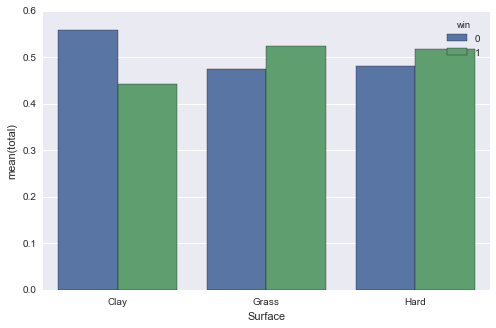

In [19]:
win_by_Surface = pd.DataFrame( win_by_Surface.unstack() ).reset_index()
win_by_Surface.columns = ["Surface", "win", "total" ]
fig2 = sns.barplot(win_by_Surface.Surface, win_by_Surface.total, hue = win_by_Surface.win )
fig2.figure.set_size_inches(8,5)

What about the dependence on rounds? The relation is not very clear but we can clearly see that upsets are unlikely to happen on the semifinals.

In [20]:
win_by_round = pd.crosstab(df.win, df.Round).apply( lambda x: x/x.sum(), axis = 0 )
win_by_round

Round,1st Round,2nd Round,3rd Round,4th Round,Quarterfinals,Semifinals,The Final
win,,,,,,,
0,0.521505,0.542056,0.469388,0.354839,0.666667,0.111111,0.4
1,0.478495,0.457944,0.530612,0.645161,0.333333,0.888889,0.6


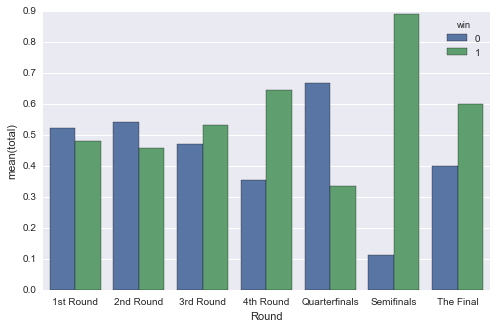

In [21]:
win_by_round = pd.DataFrame(win_by_round.unstack() ).reset_index()
win_by_round.columns = ["Round", "win", "total" ]
fig2 = sns.barplot(win_by_round.Round, win_by_round.total, hue = win_by_round.win )
fig2.figure.set_size_inches(8,5)

Let's check these results before stratification

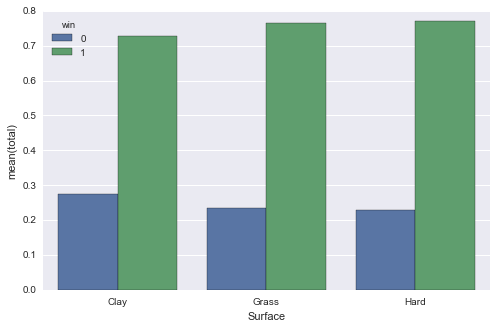

In [22]:
win_by_Surface_before_strat = pd.crosstab(df3.win, df3.Surface).apply( lambda x: x/x.sum(), axis = 0 )
win_by_Surface_before_strat = pd.DataFrame( win_by_Surface_before_strat.unstack() ).reset_index()
win_by_Surface_before_strat.columns = ["Surface", "win", "total" ]
fig2 = sns.barplot(win_by_Surface_before_strat.Surface, win_by_Surface_before_strat.total, hue = win_by_Surface_before_strat.win )
fig2.figure.set_size_inches(8,5)

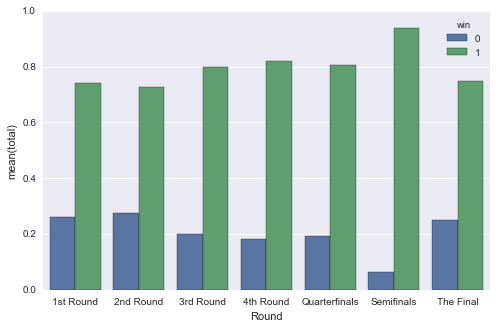

In [23]:
win_by_round_before_strat = pd.crosstab(df3.win, df3.Round).apply( lambda x: x/x.sum(), axis = 0 )
win_by_round_before_strat = pd.DataFrame(win_by_round_before_strat.unstack() ).reset_index()
win_by_round_before_strat.columns = ["Round", "win", "total" ]
fig2 = sns.barplot(win_by_round_before_strat.Round, win_by_round_before_strat.total, hue = win_by_round_before_strat.win )
fig2.figure.set_size_inches(8,5)

Dummy variables
------

To keep the dataframe cleaner we transform the `Round` entries into numbers. We then transform rounds into dummy variables

In [24]:
df1 = df.copy()
def round_number(x):
    if x == '1st Round':
        return 1
    elif x == '2nd Round':
        return 2
    elif x == '3rd Round':
        return 3
    elif x == '4th Round':
        return 4
    elif x == 'Quarterfinals':
        return 5
    elif x == 'Semifinals':
        return 6
    elif x == 'The Final':
        return 7
    
df1['Round'] = df1['Round'].apply(round_number)

dummy_ranks = pd.get_dummies(df1['Round'], prefix='Round')

df1 = df1.join(dummy_ranks.ix[:, 'Round_2':])
df1[['Round_2', 'Round_3',
       'Round_4', 'Round_5', 'Round_6', 'Round_7']] = df1[['Round_2', 'Round_3','Round_4', 'Round_5', 'Round_6', 'Round_7']].astype('int_')
df1.head()

,Date,Surface,Round,WRank,LRank,win,P1,P2,Round_2,Round_3,Round_4,Round_5,Round_6,Round_7
41984,2015-01-21,Hard,2,46,31,0,46,31,1,0,0,0,0,0
46044,2016-08-07,Grass,6,7,3,0,7,3,0,0,0,0,1,0
43308,2015-06-29,Grass,1,148,93,0,148,93,0,0,0,0,0,0
46497,2016-08-29,Hard,1,120,54,0,120,54,0,0,0,0,0,0
43345,2015-06-30,Grass,1,37,32,0,37,32,0,0,0,0,0,0


We repeat this for the `Surface` variable

In [25]:
dummy_ranks = pd.get_dummies(df1['Surface'], prefix='Surface')
dummy_ranks.head()

,Surface_Clay,Surface_Grass,Surface_Hard
41984,0.0,0.0,1.0
46044,0.0,1.0,0.0
43308,0.0,1.0,0.0
46497,0.0,0.0,1.0
43345,0.0,1.0,0.0


In [26]:
df_2 = df1.join(dummy_ranks.ix[:, 'Surface_Grass':])
df_2.drop("Surface",axis = 1,inplace=True)
df_2[['Surface_Grass','Surface_Hard']] = df_2[['Surface_Grass','Surface_Hard']].astype('int_')
df_2.drop("Round",axis = 1,inplace=True)
df_2.head()

,Date,WRank,LRank,win,P1,P2,Round_2,Round_3,Round_4,Round_5,Round_6,Round_7,Surface_Grass,Surface_Hard
41984,2015-01-21,46,31,0,46,31,1,0,0,0,0,0,0,1
46044,2016-08-07,7,3,0,7,3,0,0,0,0,1,0,1,0
43308,2015-06-29,148,93,0,148,93,0,0,0,0,0,0,1,0
46497,2016-08-29,120,54,0,120,54,0,0,0,0,0,0,0,1
43345,2015-06-30,37,32,0,37,32,0,0,0,0,0,0,1,0


We now take the logarithms of ${\cal P}_1$ and ${\cal P}_2$, then create a variable `D` 

In [27]:
df4 = df_2.copy()
df4['P1'] = np.log2(df4['P1'].astype('float64')) 
df4['P2'] = np.log2(df4['P2'].astype('float64')) 
df4['D'] = df4['P1'] - df4['P2']
df4['D'] = np.absolute(df4['D'])
df4.head()

,Date,WRank,LRank,win,P1,P2,Round_2,Round_3,Round_4,Round_5,Round_6,Round_7,Surface_Grass,Surface_Hard,D
41984,2015-01-21,46,31,0,5.523562,4.954196,1,0,0,0,0,0,0,1,0.569366
46044,2016-08-07,7,3,0,2.807355,1.584963,0,0,0,0,1,0,1,0,1.222392
43308,2015-06-29,148,93,0,7.209453,6.539159,0,0,0,0,0,0,1,0,0.670295
46497,2016-08-29,120,54,0,6.906891,5.754888,0,0,0,0,0,0,0,1,1.152003
43345,2015-06-30,37,32,0,5.209453,5.000000,0,0,0,0,0,0,1,0,0.209453


## Model 1: Logistic Regression

We now use a logistic regression to study our data.

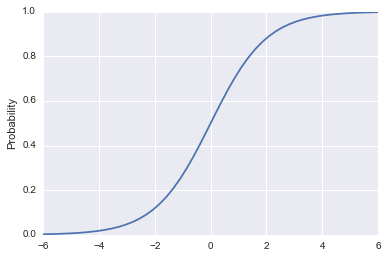

In [28]:
import numpy as np
import matplotlib.pyplot as plt
# Logit Function
def logit(x):
    return np.exp(x)  / (1 + np.exp(x)) 
    
x = np.linspace(-6,6,50, dtype=float)

y = logit(x)

plt.plot(x, y)
plt.ylabel("Probability")
plt.show()


In [251]:
df4.columns.tolist()

['Date',
 'WRank',
 'LRank',
 'win',
 'P1',
 'P2',
 'Round_2',
 'Round_3',
 'Round_4',
 'Round_5',
 'Round_6',
 'Round_7',
 'Surface_Grass',
 'Surface_Hard',
 'D']

In [29]:
feature_cols = ['Round_2',
 'Round_3',
 'Round_4',
 'Round_5',
 'Round_6',
 'Round_7',
 'Surface_Grass',
 'Surface_Hard',
 'D']

In [30]:
dfnew = df4.copy()
dfnew[feature_cols].head()

,Round_2,Round_3,Round_4,Round_5,Round_6,Round_7,Surface_Grass,Surface_Hard,D
41984,1,0,0,0,0,0,0,1,0.569366
46044,0,0,0,0,1,0,1,0,1.222392
43308,0,0,0,0,0,0,1,0,0.670295
46497,0,0,0,0,0,0,0,1,1.152003
43345,0,0,0,0,0,0,1,0,0.209453


In [31]:
X = dfnew[feature_cols]
y = dfnew.win
#pd.value_counts(dfnew['Best_of_5'].values, sort=False)

In [32]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.707070707071


In [34]:
from __future__ import print_function
print('True:', y_test.values[0:40])
print('Pred:', y_pred_class[0:40])

True: [1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0
 1 1 0]
Pred: [0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 0]


In [35]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
auc_score

0.75469387755102035

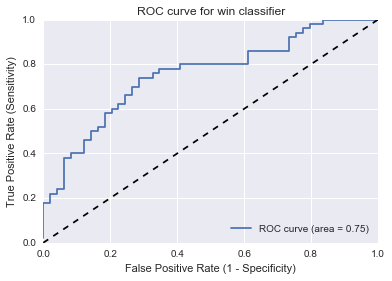

In [36]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
fig = plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for win classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [37]:
import statsmodels.api as sm

X = dfnew[feature_cols]
X = sm.add_constant(X)
y = dfnew['win']

lm = sm.Logit(y, X)
result = lm.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.584223
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                  396
Model:                          Logit   Df Residuals:                      386
Method:                           MLE   Df Model:                            9
Date:                Thu, 10 Nov 2016   Pseudo R-squ.:                  0.1571
Time:                        11:45:45   Log-Likelihood:                -231.35
converged:                       True   LL-Null:                       -274.49
                                        LLR p-value:                 9.105e-15
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            -1.4661      0.292     -5.014      0.000        -2.039    -0.893
Round_2          -0.3527      0.270     -1.306      0.192        -0.882     0.177
Round_3          -0.2240      0.364     -0.615      0.538        -0.937     0.489
Round_4           0.1382      0.449      0.308      0.758        -0.742     1.018
Round_5          -1.2500      0.841     -1.486      0.137        -2.899     0.399
Round_6           2.0958      1.103      1.900      0.057        -0.066     4.257
Round_7           0.4501      0.959      0.470      0.639        -1.429     2.329
Surface_Grass     0.5040      0.316      1.597      0.110        -0.115     1.123
Surface_Hard      0.3538      0.276      1.280      0.200        -0.188     0.895
D                 0.7876      0.108      7.313      0.000         0.576     0.999
=================================================================================
"""

In [38]:
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.72848476454293631

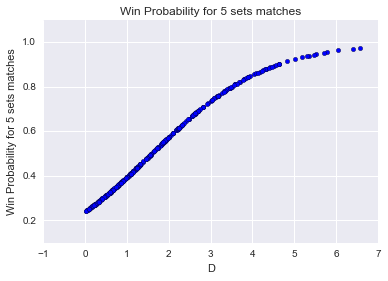

In [40]:
logreg.fit(dfnew[["D"]],dfnew["win"])
pred_probs = logreg.predict_proba(dfnew[["D"]])
plt.scatter(dfnew["D"], pred_probs[:,1])
plt.title('Win Probability for 5 sets matches')
plt.xlabel('D')
plt.ylabel('Win Probability for 5 sets matches')
plt.legend(loc="lower right")
plt.grid(True)

Decision Trees and Random Forests
-------

We now build a decision tree model to predict the upsets likelihood of a given match

In [42]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

X = dfnew[feature_cols].dropna()
y = dfnew['win']


model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [43]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('AUC {}, Average AUC {}'.format(scores, scores.mean()))

AUC [ 0.5875      0.5875      0.5625      0.6025641   0.50756082], Average AUC 0.569524983563


In [44]:
model = DecisionTreeClassifier(
                max_depth = 4,
                min_samples_leaf = 6)

model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.66625     0.720625    0.6090625   0.74621959  0.55555556], Average AUC 0.659542529586


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

X = dfnew[feature_cols].dropna()
y = dfnew['win']

model = RandomForestClassifier(n_estimators = 200)
    
model.fit(X, y)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
8,D,0.850724
7,Surface_Hard,0.025179
0,Round_2,0.025132
6,Surface_Grass,0.022049
1,Round_3,0.017896
2,Round_4,0.016429
4,Round_6,0.016345
5,Round_7,0.013936
3,Round_5,0.012309


/Users/marcotavora/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


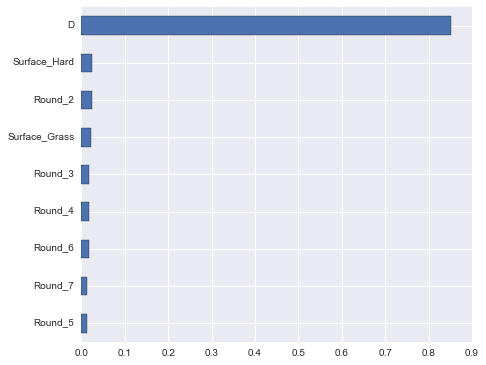

In [47]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))

In [48]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

AUC [ 0.72956841  0.66758494  0.64152893], Average AUC 0.679560759106
n trees: 1, CV AUC [ 0.65151515  0.66666667  0.5632461 ], Average AUC 0.627142638506
n trees: 11, CV AUC [ 0.74437557  0.64543159  0.62775482], Average AUC 0.672520661157
n trees: 21, CV AUC [ 0.71613866  0.65381084  0.63636364], Average AUC 0.668771043771
n trees: 31, CV AUC [ 0.72623967  0.67229109  0.64577594], Average AUC 0.681435567799
n trees: 41, CV AUC [ 0.73783287  0.65048209  0.64015152], Average AUC 0.676155494337
n trees: 51, CV AUC [ 0.72463269  0.65438476  0.64290634], Average AUC 0.673974594429
n trees: 61, CV AUC [ 0.71705693  0.66069789  0.65587695], Average AUC 0.677877257423
n trees: 71, CV AUC [ 0.73519284  0.66609275  0.64623508], Average AUC 0.682506887052
n trees: 81, CV AUC [ 0.72945363  0.65943526  0.62775482], Average AUC 0.672214569942
n trees: 91, CV AUC [ 0.74368687  0.67171717  0.63429752], Average AUC 0.683233853688


##  Best_of = 3
We now restrict our analysis to matches of Best_of = 3. 

In [189]:
import pandas as pd
df_atp = pd.read_csv('Data.csv')
df_atp['Date'] = pd.to_datetime(df_atp['Date']) 
# Restricing dates
df_atp = df_atp.loc[(df_atp['Date'] > '2014-11-09') & (df_atp['Date'] <= '2016-11-09')]
# Keeping only completed matches
df_atp = df_atp[df_atp['Comment'] == 'Completed'].drop("Comment",axis = 1)
# Rename Best of to Best_of
df_atp.rename(columns = {'Best of':'Best_of'},inplace=True)
# Choosing features
cols_to_keep = ['Date','Series','Surface', 'Round','Best_of', 'WRank','LRank']
# Dropping NaN
df_atp = df_atp[cols_to_keep].dropna()
# Dropping errors in the dataset and unimportant entries (e.g. there are very few entries for Masters Cup)
df_atp = df_atp[(df_atp['LRank'] != 'NR') & (df_atp['WRank'] != 'NR') & (df_atp['Series'] != 'Masters Cup')]
df_atp[['Best_of','WRank','LRank']] = df_atp[['Best_of','WRank','LRank']].astype(int)
def win(x):
    if x > 0:
        return 0
    elif x <= 0:
        return 1  
    
df_atp['win'] = (df_atp['WRank'] - df_atp['LRank']).apply(win)
df_atp.head()

,Date,Series,Surface,Round,Best_of,WRank,LRank,win
39530,2014-12-02,ATP250,Clay,1st Round,3,92,42,0
39531,2014-12-02,ATP250,Clay,1st Round,3,45,78,1
39532,2014-12-02,ATP250,Clay,1st Round,3,53,230,1
39533,2014-12-02,ATP250,Clay,1st Round,3,84,165,1
39534,2014-12-02,ATP250,Clay,1st Round,3,18,111,1


In [190]:
newdf = df_atp.copy()
newdf2 = newdf[(newdf['WRank'] <= 100) & (newdf['LRank'] <= 100)]
newdf2.head()

,Date,Series,Surface,Round,Best_of,WRank,LRank,win
39530,2014-12-02,ATP250,Clay,1st Round,3,92,42,0
39531,2014-12-02,ATP250,Clay,1st Round,3,45,78,1
39537,2014-12-02,ATP250,Clay,2nd Round,3,14,58,1
39560,2014-12-02,ATP250,Hard,1st Round,3,96,56,0
39563,2014-12-02,ATP250,Hard,2nd Round,3,85,81,0


In [191]:
df3 = newdf2.copy()
df3 = df3[df3['Best_of'] == 3]
# Drop Best_of and Series columns
df3.drop("Series",axis = 1,inplace=True)
df3.drop("Best_of",axis = 1,inplace=True)
df3.head()

,Date,Surface,Round,WRank,LRank,win
39530,2014-12-02,Clay,1st Round,92,42,0
39531,2014-12-02,Clay,1st Round,45,78,1
39537,2014-12-02,Clay,2nd Round,14,58,1
39560,2014-12-02,Hard,1st Round,96,56,0
39563,2014-12-02,Hard,2nd Round,85,81,0


In [192]:
y_0 = df3[df3.win == 0] 
y_1 = df3[df3.win == 1] 
n = min([len(y_0), len(y_1)]) 
y_0 = y_0.sample(n = n, random_state = 0) 
y_1 = y_1.sample(n = n, random_state = 0)
df_strat = pd.concat([y_0, y_1]) 
X_strat = df_strat[['Date', 'Surface', 'Round','WRank', 'LRank']]
y_strat = df_strat.win

In [193]:
X_strat_1=X_strat.copy()
X_strat_1['win']=y_strat
X_strat_1.head()

,Date,Surface,Round,WRank,LRank,win
43714,2015-12-08,Hard,2nd Round,49,34,0
42431,2015-03-15,Hard,2nd Round,41,32,0
45333,2016-04-20,Clay,2nd Round,51,35,0
42802,2015-01-05,Clay,Quarterfinals,63,50,0
45438,2016-01-05,Clay,The Final,87,29,0


In [194]:
df = X_strat_1.copy()
df["P1"] = df[["WRank", "LRank"]].max(axis=1)
df["P2"] = df[["WRank", "LRank"]].min(axis=1)
df.head()

,Date,Surface,Round,WRank,LRank,win,P1,P2
43714,2015-12-08,Hard,2nd Round,49,34,0,49,34
42431,2015-03-15,Hard,2nd Round,41,32,0,41,32
45333,2016-04-20,Clay,2nd Round,51,35,0,51,35
42802,2015-01-05,Clay,Quarterfinals,63,50,0,63,50
45438,2016-01-05,Clay,The Final,87,29,0,87,29


## Exploratory Analysis for Best_of = 3

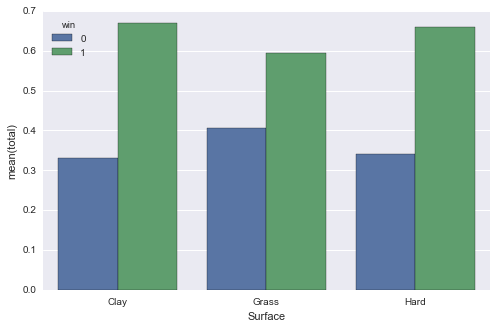

In [195]:
#Without stratification
win_by_Surface = pd.crosstab(df3.win, df3.Surface).apply( lambda x: x/x.sum(), axis = 0 )
win_by_Surface
win_by_Surface = pd.DataFrame( win_by_Surface.unstack() ).reset_index()
win_by_Surface.columns = ["Surface", "win", "total" ]
fig2 = sns.barplot(win_by_Surface.Surface, win_by_Surface.total, hue = win_by_Surface.win )
fig2.figure.set_size_inches(8,5)

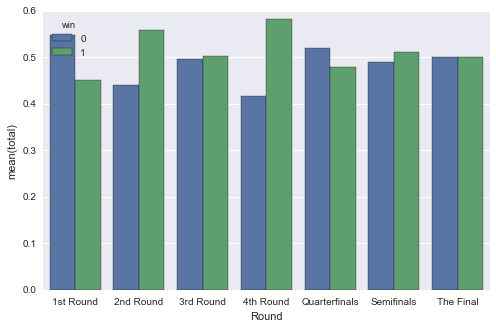

In [196]:
#without stratification
win_by_round = pd.crosstab(df.win, df.Round).apply( lambda x: x/x.sum(), axis = 0 )
win_by_round
win_by_round = pd.DataFrame(win_by_round.unstack() ).reset_index()
win_by_round.columns = ["Round", "win", "total" ]
fig2 = sns.barplot(win_by_round.Round, win_by_round.total, hue = win_by_round.win )
fig2.figure.set_size_inches(8,5)

Dummy variables
------

In [197]:
df1 = df.copy()
def round_number(x):
    if x == '1st Round':
        return 1
    elif x == '2nd Round':
        return 2
    elif x == '3rd Round':
        return 3
    elif x == '4th Round':
        return 4
    elif x == 'Quarterfinals':
        return 5
    elif x == 'Semifinals':
        return 6
    elif x == 'The Final':
        return 7
    
df1['Round'] = df1['Round'].apply(round_number)

dummy_ranks = pd.get_dummies(df1['Round'], prefix='Round')

df1 = df1.join(dummy_ranks.ix[:, 'Round_2':])
df1[['Round_2', 'Round_3',
       'Round_4', 'Round_5', 'Round_6', 'Round_7']] = df1[['Round_2', 'Round_3','Round_4', 'Round_5', 'Round_6', 'Round_7']].astype('int_')
df1.head()

,Date,Surface,Round,WRank,LRank,win,P1,P2,Round_2,Round_3,Round_4,Round_5,Round_6,Round_7
43714,2015-12-08,Hard,2,49,34,0,49,34,1,0,0,0,0,0
42431,2015-03-15,Hard,2,41,32,0,41,32,1,0,0,0,0,0
45333,2016-04-20,Clay,2,51,35,0,51,35,1,0,0,0,0,0
42802,2015-01-05,Clay,5,63,50,0,63,50,0,0,0,1,0,0
45438,2016-01-05,Clay,7,87,29,0,87,29,0,0,0,0,0,1


In [198]:
dummy_ranks = pd.get_dummies(df1['Surface'], prefix='Surface')
df_2 = df1.join(dummy_ranks.ix[:, 'Surface_Grass':])
df_2.drop("Surface",axis = 1,inplace=True)
df_2[['Surface_Grass','Surface_Hard']] = df_2[['Surface_Grass','Surface_Hard']].astype('int_')
df_2.drop("Round",axis = 1,inplace=True)
df_2.head()

,Date,WRank,LRank,win,P1,P2,Round_2,Round_3,Round_4,Round_5,Round_6,Round_7,Surface_Grass,Surface_Hard
43714,2015-12-08,49,34,0,49,34,1,0,0,0,0,0,0,1
42431,2015-03-15,41,32,0,41,32,1,0,0,0,0,0,0,1
45333,2016-04-20,51,35,0,51,35,1,0,0,0,0,0,0,0
42802,2015-01-05,63,50,0,63,50,0,0,0,1,0,0,0,0
45438,2016-01-05,87,29,0,87,29,0,0,0,0,0,1,0,0


In [199]:
df4 = df_2.copy()
df4['P1'] = np.log2(df4['P1'].astype('float64')) 
df4['P2'] = np.log2(df4['P2'].astype('float64')) 
df4['D'] = df4['P1'] - df4['P2']
df4['D'] = np.absolute(df4['D'])
df4.head()

,Date,WRank,LRank,win,P1,P2,Round_2,Round_3,Round_4,Round_5,Round_6,Round_7,Surface_Grass,Surface_Hard,D
43714,2015-12-08,49,34,0,5.614710,5.087463,1,0,0,0,0,0,0,1,0.527247
42431,2015-03-15,41,32,0,5.357552,5.000000,1,0,0,0,0,0,0,1,0.357552
45333,2016-04-20,51,35,0,5.672425,5.129283,1,0,0,0,0,0,0,0,0.543142
42802,2015-01-05,63,50,0,5.977280,5.643856,0,0,0,1,0,0,0,0,0.333424
45438,2016-01-05,87,29,0,6.442943,4.857981,0,0,0,0,0,1,0,0,1.584963


## Model 1: Logistic Regression

In [61]:
df4.columns.tolist()

['Date',
 'WRank',
 'LRank',
 'win',
 'P1',
 'P2',
 'Round_2',
 'Round_3',
 'Round_4',
 'Round_5',
 'Round_6',
 'Round_7',
 'Surface_Grass',
 'Surface_Hard',
 'D']

In [266]:
#feature_cols = ['P1','P2','Round_2','Round_3','Round_4','Round_5','Round_6','Round_7','Surface_Grass','Surface_Hard','D']
feature_cols = ['D','Surface_Hard','Surface_Grass','Round_6','Round_5','Round_3']

In [267]:
dfnew = df4.copy()
X = dfnew[feature_cols]
y = dfnew.win
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
print(auc_score)

0.591885441527
0.620670798396


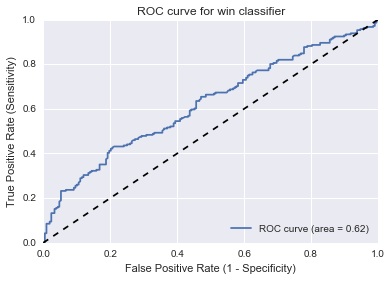

In [268]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
fig = plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for win classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [269]:
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.64683339949421492

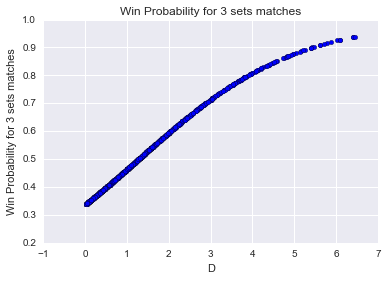

In [271]:
logreg.fit(dfnew[["D"]],dfnew["win"])
pred_probs = logreg.predict_proba(dfnew[["D"]])
plt.scatter(dfnew["D"], pred_probs[:,1])
plt.title('Win Probability for 3 sets matches')
plt.xlabel('D')
plt.ylabel('Win Probability for 3 sets matches')
plt.legend(loc="lower right")
plt.grid(True)

## Decision Trees and Random Forests

In [272]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

X = dfnew[feature_cols].dropna()
y = dfnew['win']


model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [273]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('AUC {}, Average AUC {}'.format(scores, scores.mean()))

AUC [ 0.55257937  0.57486536  0.53993056  0.5170318   0.49804582], Average AUC 0.536490582524


In [274]:
model = DecisionTreeClassifier(
                max_depth = 4,
                min_samples_leaf = 6)

model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.61034935  0.67795139  0.61050879  0.6052207   0.55577468], Average AUC 0.611960979666


In [275]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

X = dfnew[feature_cols].dropna()
y = dfnew['win']

model = RandomForestClassifier(n_estimators = 200)
    
model.fit(X, y)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [276]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
0,D,0.958857
1,Surface_Hard,0.010787
2,Surface_Grass,0.008321
5,Round_3,0.007937
4,Round_5,0.007525
3,Round_6,0.006573


/Users/marcotavora/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


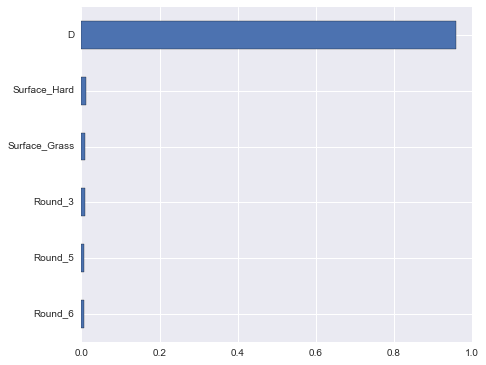

In [277]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))

In [278]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

AUC [ 0.56410714  0.55746329  0.54182243], Average AUC 0.554464288773
n trees: 1, CV AUC [ 0.54352679  0.52182012  0.52169808], Average AUC 0.529014994355
n trees: 11, CV AUC [ 0.57148597  0.5538084   0.55104636], Average AUC 0.558780245814
n trees: 21, CV AUC [ 0.55047194  0.54987731  0.53842448], Average AUC 0.546257911153
n trees: 31, CV AUC [ 0.57475765  0.55339731  0.54241338], Average AUC 0.556856114695
n trees: 41, CV AUC [ 0.55816327  0.5527357   0.54013952], Average AUC 0.550346161769
n trees: 51, CV AUC [ 0.5441199   0.55787438  0.53792988], Average AUC 0.546641388544
n trees: 61, CV AUC [ 0.56126913  0.55277424  0.54369805], Average AUC 0.552580476248
n trees: 71, CV AUC [ 0.56765306  0.55975643  0.53744813], Average AUC 0.554952539745
n trees: 81, CV AUC [ 0.56794643  0.55797716  0.54158477], Average AUC 0.555836118697
n trees: 91, CV AUC [ 0.5585523   0.55412315  0.53579733], Average AUC 0.549490924948
